In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import io
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from keras.models import Model
from glob import glob
from PIL import Image

In [ ]:
 class DiffusionNetStep(tf.keras.layers.Layer):
    def __init__(self, rbf,n_rbf=63, n_channels=3, n_filters=5, filter_size=5):
        super(DiffusionNetStep, self).__init__()
        self.padding = filter_size // 2 + (filter_size - 2 * (filter_size // 2)) - 1
        self.conv = tf.keras.layers.Conv2D(n_filters, filter_size, padding='valid', use_bias=False)
        self.means = rbf["means"]
        self.std = rbf["std"]
        n_rbf = self.means.shape[0]
        self.weights_rbf = tf.Variable(tf.ones((n_filters, n_rbf)) / n_rbf)  # trainable param
        self.reaction_weight = tf.Variable(tf.ones((1,), dtype=tf.float32))   # trainable param
    
    # Gaussian RBF exp((u-mean/std)^2)
    def compute_nonlinearity(self, u):
        s = tf.zeros_like(u, dtype=tf.float32)
        for i in range(n_rbf):
            v = (u - self.means[i]) / self.std[i]
            v = tf.math.exp(-tf.math.pow(v, 2))
            v = tf.expand_dims(tf.expand_dims(self.weights_rbf[:,i], 0), 1) * v
            s += v
        return s
    
    def compute_diffusion(self, u):
        # First conv
        u = tf.pad(u, [[0,0],[self.padding,self.padding],[self.padding,self.padding],[0,0]], mode="SYMMETRIC")
        #u = tf.nn.conv2d(u, rotated_kernels_weights, strides=[1,1,1,1], padding='VALID')
        u = self.conv(u)

        # Non linearity
        u = self.compute_nonlinearity(u)

        # Rotated conv
        #rotated_kernels_weights = tf.transpose(tf.reverse(self.conv.weights, [2,3]), [0,1,3,2]) # rotate 2 times conv1 weights
        rotated_kernels_weights = tf.reverse(self.conv.weights, [2,3])
        rotated_kernels_weights=tf.squeeze(rotated_kernels_weights, axis=0)
        rotated_kernels_weights = tf.transpose(rotated_kernels_weights, perm=[0, 1, 3, 2])
        u = tf.pad(u, [[0,0],[self.padding,self.padding],[self.padding,self.padding],[0,0]], mode="SYMMETRIC")
        u = tf.nn.conv2d(u, rotated_kernels_weights, strides=[1,1,1,1], padding='VALID')
        return u
    
    def call(self,u, f):
        u = u - (self.compute_diffusion(u) + self.reaction_weight * (u - f))
        return u


class DiffusionNet(tf.keras.Model):
    def __init__(self, n_rbf=63, T=5, **dnet_args):
        super(DiffusionNet, self).__init__()
        means = tf.Variable(tf.random.normal((n_rbf,), dtype=tf.float32))
        std = tf.Variable(tf.random.normal((n_rbf,), dtype=tf.float32) + 1.0)
        rbfs = {"means": means, "std": std}
        self.dnets = [DiffusionNetStep(rbfs, **dnet_args) for i in range(T)]
    
    def step(self, u, f, i):
        return self.dnets[i](u, f)
    
    def call(self, f):
        u=tf.identity(f)
        for i in range(len(self.dnets)):
            u = self.step(u, f, i)
        return u

In [ ]:
n_rbf=63

In [ ]:
# rbf = {"means": np.array([random.uniform(-10, 10) for _ in range(n_rbf)]),"std":np.array([random.uniform(1,5) for _ in range(n_rbf)])}
# dfnet_step = DiffusionNetStep(rbf, n_channels=3, n_filters=5, filter_size=5)
dfnet = DiffusionNet()
#reaction_difusion=Model()

In [ ]:
import tensorflow.keras.backend as K

def psnr(y_true, y_pred):
    return -10. * K.log(K.mean(K.square(y_pred - y_true)))

In [ ]:
dfnet.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[psnr])

In [ ]:
dfnet.optimizer.lr=0.0005

In [ ]:
print(dfnet.optimizer.lr)

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0005>


In [ ]:
!tar -xvf '/content/BSDS300-images.tar'

BSDS300/images/
BSDS300/images/train/
BSDS300/images/train/159029.jpg
BSDS300/images/train/20008.jpg
BSDS300/images/train/155060.jpg
BSDS300/images/train/286092.jpg
BSDS300/images/train/100075.jpg
BSDS300/images/train/61060.jpg
BSDS300/images/train/46076.jpg
BSDS300/images/train/301007.jpg
BSDS300/images/train/26031.jpg
BSDS300/images/train/232038.jpg
BSDS300/images/train/45077.jpg
BSDS300/images/train/365025.jpg
BSDS300/images/train/188091.jpg
BSDS300/images/train/299091.jpg
BSDS300/images/train/181079.jpg
BSDS300/images/train/22090.jpg
BSDS300/images/train/370036.jpg
BSDS300/images/train/15088.jpg
BSDS300/images/train/22093.jpg
BSDS300/images/train/376020.jpg
BSDS300/images/train/187071.jpg
BSDS300/images/train/105053.jpg
BSDS300/images/train/271008.jpg
BSDS300/images/train/277095.jpg
BSDS300/images/train/198023.jpg
BSDS300/images/train/65074.jpg
BSDS300/images/train/189003.jpg
BSDS300/images/train/187029.jpg
BSDS300/images/train/103041.jpg
BSDS300/images/train/163014.jpg
BSDS300/ima

In [ ]:
# from shutil import *
# rmtree("/content/data")

In [ ]:
!mkdir /content/data

In [ ]:
!mkdir /content/data/train

In [ ]:
!mkdir /content/data/test

In [ ]:
!mkdir /content/data/train/input
!mkdir /content/data/train/output
!mkdir /content/data/test/input
!mkdir /content/data/test/output


In [ ]:
input_save_train_images_path="/content/data/train/input"
output_save_train_images_path="/content/data/train/output"
input_save_test_images_path="/content/data/test/input"
output_save_test_images_path="/content/data/test/output"

save_train_images_path="/content/data/train"
save_test_images_path="/content/data/test"
train_images_path="/content/BSDS300/images/train"
test_images_path="/content/BSDS300/images/test"


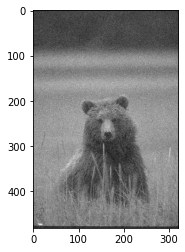

In [ ]:
paths= sorted(glob(train_images_path+"/*"))
img = np.asarray(Image.open(paths[1]))
img_gray=rgb2gray(img)
gaussian = np.random.normal(0, 0.05, (img_gray.shape[0], img_gray.shape[1]))
gaussian = gaussian.reshape(img_gray.shape)
noisy_image = img_gray + gaussian
plt.imshow(noisy_image,cmap='gray')

In [ ]:
img_gray.shape

(481, 321)

In [ ]:
def add_noise(images_path,save_path):
    paths= sorted(glob(images_path+"/*"))
    for i in range(len(paths)):
        img = np.asarray(Image.open(paths[i]))
        img_gray=rgb2gray(img)
        # Add Gaussian noise
        mean = 0
        sigma = 0.05
        gaussian = np.random.normal(mean, sigma, (img_gray.shape[0], img_gray.shape[1]))
        gaussian = gaussian.reshape(img_gray.shape)
        #uniform
        #noise=0.5*np.random.rand(img_gray.shape[0], img_gray.shape[1])
        noisy_image = img_gray + gaussian
        #save the image
        plt.imsave(save_path+"/output"+"/label"+str(i)+".png",img_gray,cmap='gray')
        plt.imsave(save_path+"/input"+"/noisy"+str(i)+".png",noisy_image,cmap='gray')


In [ ]:
add_noise(train_images_path,save_train_images_path)
add_noise(test_images_path,save_test_images_path)

In [ ]:
input_train=sorted(glob(input_save_train_images_path+"/*"))
output_train=sorted(glob(output_save_train_images_path+"/*"))
import pandas as pd
data={"input_train":input_train,"output_train":output_train}
df = pd.DataFrame(data)
df

,input_train,output_train
0,/content/data/train/input/noisy0.png,/content/data/train/output/label0.png
1,/content/data/train/input/noisy1.png,/content/data/train/output/label1.png
2,/content/data/train/input/noisy10.png,/content/data/train/output/label10.png
3,/content/data/train/input/noisy100.png,/content/data/train/output/label100.png
4,/content/data/train/input/noisy101.png,/content/data/train/output/label101.png
...,...,...
195,/content/data/train/input/noisy95.png,/content/data/train/output/label95.png
196,/content/data/train/input/noisy96.png,/content/data/train/output/label96.png
197,/content/data/train/input/noisy97.png,/content/data/train/output/label97.png
198,/content/data/train/input/noisy98.png,/content/data/train/output/label98.png


In [ ]:
input_test=sorted(glob(input_save_test_images_path+"/*"))
output_test=sorted(glob(output_save_test_images_path+"/*"))
import pandas as pd
data_test={"input_test":input_test,"output_test":output_test}
df_test = pd.DataFrame(data_test)
df_test

,input_test,output_test
0,/content/data/test/input/noisy0.png,/content/data/test/output/label0.png
1,/content/data/test/input/noisy1.png,/content/data/test/output/label1.png
2,/content/data/test/input/noisy10.png,/content/data/test/output/label10.png
3,/content/data/test/input/noisy11.png,/content/data/test/output/label11.png
4,/content/data/test/input/noisy12.png,/content/data/test/output/label12.png
...,...,...
95,/content/data/test/input/noisy95.png,/content/data/test/output/label95.png
96,/content/data/test/input/noisy96.png,/content/data/test/output/label96.png
97,/content/data/test/input/noisy97.png,/content/data/test/output/label97.png
98,/content/data/test/input/noisy98.png,/content/data/test/output/label98.png


In [ ]:
train_datagen = ImageDataGenerator(
        #rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
        )
test_datagen = ImageDataGenerator()

input_train_generator = train_datagen.flow_from_dataframe(
        df, x_col='input_train',
        target_size=(224, 224),
        batch_size=10,
        color_mode='grayscale',
        class_mode=None,
        seed=1)
output_train_generator = train_datagen.flow_from_dataframe(
        df, x_col='output_train',
        target_size=(224, 224),
        batch_size=10,
        color_mode='grayscale',
        class_mode=None,
        seed=1)
train_generator = zip(input_train_generator, output_train_generator)

input_validation_generator = test_datagen.flow_from_dataframe(
        df_test, x_col='input_test',
        target_size=(224, 224),
        batch_size=10,
        color_mode='grayscale',
        class_mode=None,
        seed=1)
output_validation_generator = test_datagen.flow_from_dataframe(
        df_test, x_col='output_test',
        target_size=(224, 224),
        batch_size=10,
        color_mode='grayscale',
        class_mode=None,
        seed=1)
test_generator = zip(input_validation_generator, output_validation_generator)


Found 200 validated image filenames.
Found 200 validated image filenames.
Found 100 validated image filenames.
Found 100 validated image filenames.


In [ ]:
dfnet.fit(
        train_generator,
        steps_per_epoch=len(df)//10,
        epochs=50,
        validation_data=test_generator,
        validation_steps=len(df_test)//10)

Epoch 1/50
20/20 [==============================] - 22s 1s/step - loss: 212.9369 - psnr: -53.5553 - val_loss: 303.2224 - val_psnr: -56.9338
Epoch 2/50
20/20 [==============================] - 24s 1s/step - loss: 208.9714 - psnr: -53.1988 - val_loss: 315.1187 - val_psnr: -57.2497
Epoch 3/50
20/20 [==============================] - 22s 1s/step - loss: 214.7580 - psnr: -53.3480 - val_loss: 329.2803 - val_psnr: -57.8780
Epoch 4/50
20/20 [==============================] - 22s 1s/step - loss: 219.9423 - psnr: -53.7822 - val_loss: 283.5264 - val_psnr: -56.4226
Epoch 5/50
20/20 [==============================] - 24s 1s/step - loss: 204.0828 - psnr: -53.0123 - val_loss: 295.3427 - val_psnr: -56.7112
Epoch 6/50
20/20 [==============================] - 22s 1s/step - loss: 214.0402 - psnr: -53.4352 - val_loss: 308.8492 - val_psnr: -57.2422
Epoch 7/50
20/20 [==============================] - 22s 1s/step - loss: 197.8383 - psnr: -52.6426 - val_loss: 293.1407 - val_psnr: -56.6823
Epoch 8/50
20/20 [==

In [ ]:
loss=dfnet.history.history['loss']
val_loss=dfnet.history.history['val_loss']
psnr=dfnet.history.history['psnr']
val_psnr=dfnet.history.history['val_psnr']

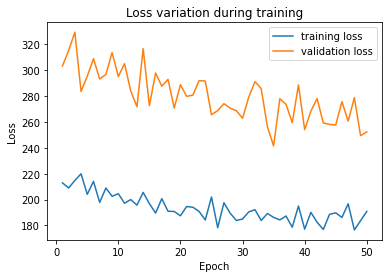

In [ ]:
import matplotlib.pyplot as plt 
Epochs=[i+1 for i in range(len(loss))]
plt.plot(Epochs,loss,label='training loss')
plt.plot(Epochs,val_loss,label='validation loss')
plt.title('Loss variation during training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

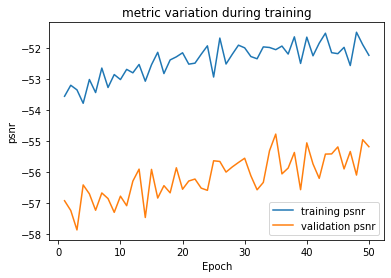

In [ ]:
plt.plot(Epochs,psnr,label='training psnr')
plt.plot(Epochs,val_psnr,label='validation psnr')
plt.title('metric variation during training')
plt.xlabel('Epoch')
plt.ylabel('psnr')
plt.legend()
plt.show()

1/1 [==============================] - 0s 54ms/step


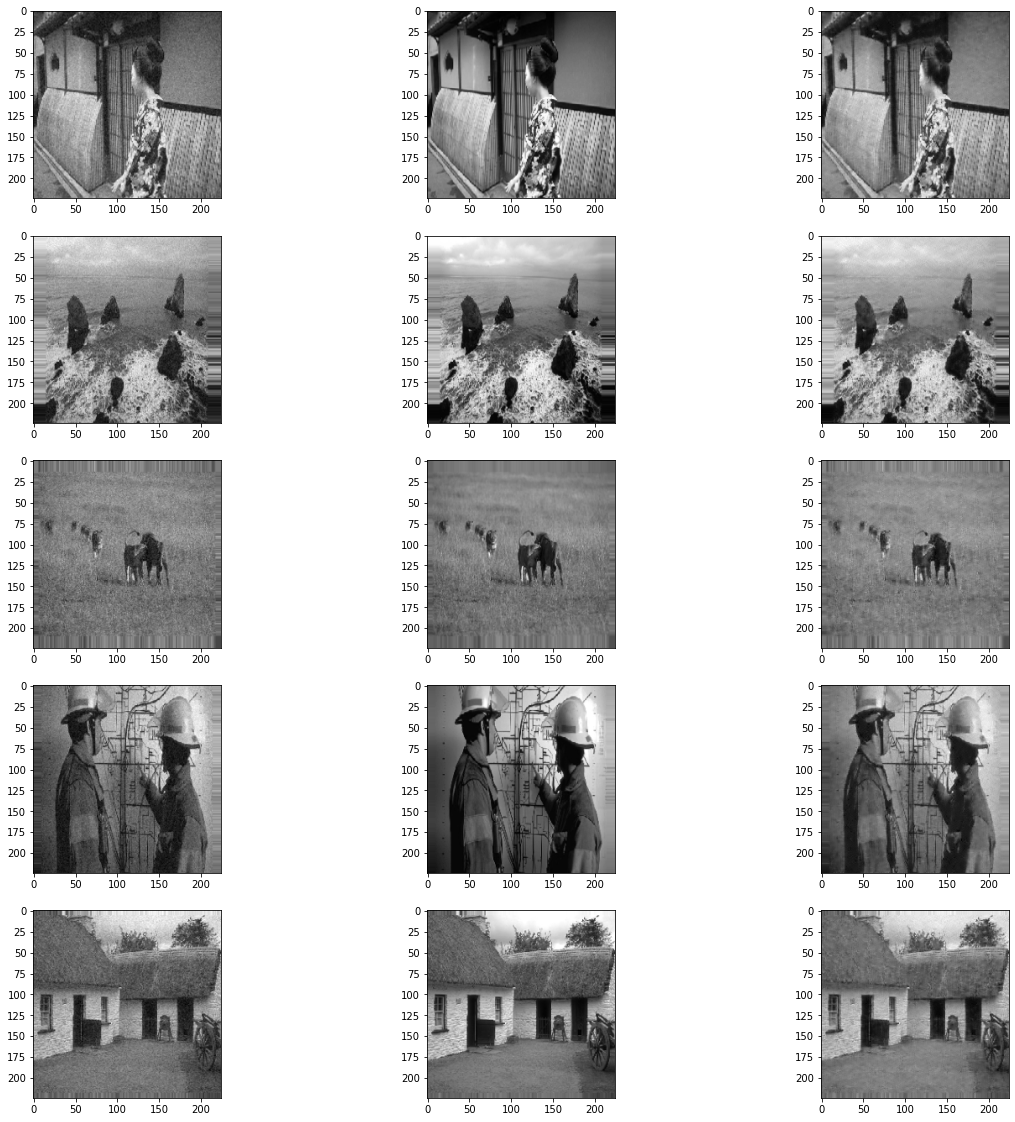

In [ ]:
fig, ax = plt.subplots(5,3,figsize=(20,20))
for i in range(5):
    input,output=next(train_generator)
    ax[i,0].imshow(np.squeeze(input[1]),cmap='gray')
    ax[i,1].imshow(np.squeeze(output[1]),cmap='gray')
    input_1 = input[1][np.newaxis, :, :, : ]
    output_hat=dfnet.predict(input_1)
    ax[i,2].imshow(np.squeeze(output_hat),cmap='gray')
plt.show()